In [67]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt


import torch
#from torch import Tensor as tensor
from torch import nn
from torch.nn  import functional as F
from torch.autograd import Variable

from scipy.integrate import odeint
from scipy.integrate import RK45


from torch.autograd.functional import jacobian
import random



use_cuda = torch.cuda.is_available() #also worsk for AMD-ROCm
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cpu device


# Pendulum
$$\frac{d^2 \theta}{dt^2}  +  \lambda\frac{d\theta}{dt} +  \frac{g}{l}sin(\theta) $$

In [68]:
def pend(y,t,b,c):
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt

b = 0.25
c = 5

theta_0 = -np.pi
omega_0 = 1
 
y0 = [theta_0 , omega_0]

t_final = 10

t = np.arange(0, 10, 0.001)

sol = odeint(pend,y0, t, args=(b,c))


In [69]:
theta = sol[:, 0]
omega = sol[:, 1]

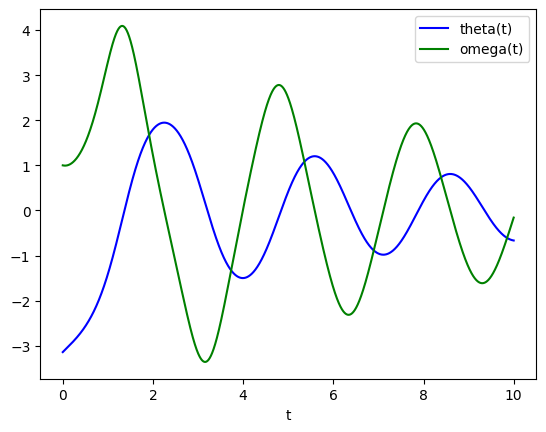

In [70]:
plt.plot(t, theta, 'b', label='theta(t)')
plt.plot(t, omega, 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.show()

# Neural ODE with ajoint-sensitivity-method

$$
x: \mathbb{R} \rightarrow  \mathbb{R}^{N_1 \times N_2} \\
N_1 \ldots \text{size of batch} \\
N_2 \ldots \text{size of vector} \\
x^i_j \equiv x(t) \\
$$
$$
\mathcal{L} : \mathbb{R}^{N_1 \times N_2} \times \underbrace{\mathbb{R}^{N_1 \times N_2}}_{\text{prediction}}  \rightarrow \mathbb{R} \\
$$
$$
a^i_j \equiv a = \frac{\partial \mathcal{L}}{\partial x(t)} \\
\dot x = f(x(t), p^a) \\

\frac{da}{dt} = - a^T \frac{\partial f}{\partial x} \\

\frac{d\mathcal{L}}{dp^a} = - \int_{t_1}^{t_0} dt \sum_i \sum_j a^j_i \frac{\partial f^i_j}{\partial p^a }  $$

$$
x_{n-1} = x_n - \Delta t \ f(x_n, p)
$$



$$
a(1-\Delta t) = a(1) + \Delta t \ a(1)\frac{\partial f(x(t), p)}{\partial x(t)}|_{t=1}
$$
$$
\Rightarrow a_{n-1} = (1 + \Delta t )\ a_n\frac{\partial f(x_n, p)}{\partial x_n} 
$$



In [71]:
def ode_solve(func, x, propagation_time, delta_t, return_seq=False):
    """
    solves the differential equation : dx/dt = f(x(t)) using eulers method

    Parameters
    ----------
    func :  python function
            Parameters
            ----------
            x : torch.Tensor    

            Returns
            -------
            torch.Tensor
    
    x : torch.Tensor
        input for func (singlet or whole batch)

    propagation_time : float
    delta_t : float 
        accuracy of solution
    return_seq : bool
        flag for returning whole sequence or not

    
    Returns
    -------
    torch.tensor

    """
    time = torch.arange(start=0, end=propagation_time, step=delta_t, requires_grad=False)
    x = x.clone().detach()
    if not return_seq:
        for t in time:
            x = x + delta_t * func(x)
        return x
    if return_seq:
        outputs = torch.zeros(time.shape[0], x.shape[1])
        for i,_ in enumerate(time):
            x = x + delta_t * func(x)
            outputs[i] = x
        return outputs

In [72]:
class PendelumNetwork(nn.Module):
    def __init__(self):
        super(PendelumNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 10, dtype=float),
            nn.Sigmoid(),
            nn.Linear(10, 10, dtype=float),
            nn.Sigmoid(),
            nn.Linear(10, 10, dtype=float),
            nn.Sigmoid(),
            nn.Linear(10, 10, dtype=float),
            nn.Sigmoid(),
            nn.Linear(10, 10, dtype=float),
            nn.Sigmoid(),
            nn.Linear(10, 10, dtype=float),
            nn.Sigmoid(),

            
            nn.Linear(10, 2, dtype=float)
        )
    def forward(self,x): 
        """implements f(x)
        x = (theta, omega)
        theta ... angle
        omega ... angular velocity

        Parameters
        ----------
        x : torch.tensor 
            shape = (2,N)

        Returns
        -------
        torch.tensor

        """
        return self.linear_relu_stack(x)

    def flatten_parameters(self):
        """
        Returns
        -------
        torch.Tensor: 
            flat parameters
        """
        flat_parameters = []
        for p in self.parameters():
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

    def get_adfdp(self, x, a):
        with torch.enable_grad():
            adfdp = torch.autograd.grad(outputs=self.forward(x), inputs=tuple(self.parameters()), grad_outputs=(a),
                allow_unused=True, retain_graph=True
            )
            # grad method automatically sums gradients for batch items, we have to expand them back 
            if adfdp is not None:
                adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
                adfdp = adfdp.expand(x.shape[0], -1) / x.shape[0]
            return adfdp

        

In [73]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, flat_parameters, func, delta_t, propagation_time, return_seq=False):
        
        if return_seq:
            return ode_solve(func, x,  propagation_time, delta_t, return_seq)
        else:
            output = ode_solve(func, x, propagation_time, delta_t, return_seq)
            ctx.func = func
            ctx.delta_t = delta_t
            ctx.propagation_time = propagation_time
            ctx.save_for_backward(output.clone(), flat_parameters)


            return output
        
    @staticmethod
    def backward(ctx, dL_dz):
        func = ctx.func
        delta_t = ctx.delta_t
        propagation_time = ctx.propagation_time
        x , flat_parameters = ctx.saved_tensors
        a =  (-1) * dL_dz.detach() #<--- detach very important

        #def one_euler_backward_step(func,x, delta_t):
        #    return (x - delta_t * func(x)).detach() #<--- detach very important

    

        time = torch.arange(start=0, end=propagation_time, step=delta_t, requires_grad=False)

        result = torch.zeros((x.shape[0], flat_parameters.shape[0]), requires_grad=False, dtype=float).to(a)
        for t in time:
            result -= delta_t * func.get_adfdp(x, a)

       
            x = x.detach().requires_grad_(True)
            with torch.enable_grad():
                a = (a + delta_t *  torch.autograd.grad(outputs=func(x), inputs=x, grad_outputs=a, allow_unused=True, retain_graph=True)[0]).detach()
                    
            x = (x - delta_t * func(x)).detach()

   

        return None, result, None, None, None, None

In [74]:
class NeuralODE(nn.Module):
    def __init__(self, func, delta_t):
        super(NeuralODE, self).__init__()
        self.func = func
        self.delta_t = delta_t
    
    def forward(self, x, propagation_time, return_seq=False, use_adjoint = True):
        if use_adjoint:
            return ODEAdjoint.apply(x, self.func.flatten_parameters(), self.func, self.delta_t , propagation_time, return_seq)
        else:
            return ode_solve(self.func, x,  propagation_time, self.delta_t, return_seq)
           
        

In [75]:
def create_data_set(theta, omega, time,  propagation_index=25, number_of_samples=200):
    """ x_i -> x_f
        x_i ... initial state
        x_f ... final state
        x_i = [theta_i, omega_i]
        x_f = [theta_f, omega_f]
        data_set = [[x_i, x_f]
                    [...]
                    ...
                    ]

    Parameters
    ----------
    theta : np.array or torch.tensor
        angle
    omega : np.array or torch.tensor
        angular velocity
   
    propagation_index : int
    
    number_of_samples : int
    
    Returns
    -------
    torch.Tensor, torch.Tensor
        data_set, and selcted times
    """
    x_i = []
    x_f = []
    data_set = torch.zeros((2,number_of_samples,2), dtype=float)
    times = []
    while len(x_i) < number_of_samples:

        index = int(random.uniform(0, len(theta))) #selectes random index

        if index+propagation_index >= len(theta):
            continue

        x_i.append([theta[index], omega[index]])
        x_f.append([theta[index+propagation_index], omega[index+propagation_index]])
        times.append(time[index])
    x_i = torch.tensor(x_i)
    x_f = torch.tensor(x_f)
    times = torch.tensor(times)
    data_set[0][:] = x_i
    data_set[1][:] = x_f
    return data_set, times

In [76]:
def create_batches(data_set, batch_size=64):
    """
    creates batches
    data is not shuffled and dropes last batch if size would be smaller than batch_size

    Parameters
    ----------
    data_set : troch.tensor 
        data_set[0] ... input
        data_set[1] ... output
    
        shape = (2,N_1,N_2)
        N_1 ... number of samples
        N_2 ... size of vector

    batch_size : int

    Retruns
    -------
    troch.Tensor, torch.Tensor 
        shape(Number of batches, 2.. init and final, number of data points, vector size)
    

    """
    number_of_batches = int(data_set.shape[1]/batch_size)
    batches = torch.zeros((number_of_batches,2,batch_size,data_set.shape[2]), dtype=float)
    for i in range(number_of_batches-1):
        batch = torch.zeros((2,batch_size,data_set.shape[2]), dtype=float)
        batch[0] = data_set[0][i*batch_size:(i+1)*batch_size][:]
        batch[1] = data_set[1][i*batch_size:(i+1)*batch_size][:] 
        batches[i] = batch
    
    return batches[:int(number_of_batches*0.75)], batches[int(number_of_batches*0.75):]


In [ ]:
propagation_index = 10
propagation_time = t[propagation_index]
print(propagation_time)
batch_size = 64
data_set, times = create_data_set(theta=theta, omega=omega, time = t, propagation_index=propagation_index, number_of_samples=batch_size*5)
train, test = create_batches(data_set=data_set, batch_size=batch_size)
print(train.shape)
print(test.shape)


0.01
torch.Size([3, 2, 64, 2])
torch.Size([2, 2, 64, 2])


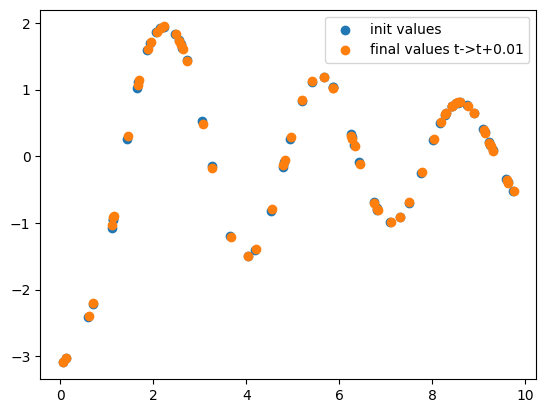

In [ ]:
#training sample for first batch

first_batch = train[0]
times = times[:batch_size]

x_i = first_batch[0]
x_f = first_batch[1]

theta_i = x_i.T[0]
theta_f = x_f.T[0]

omega_i = x_i.T[1]
omega_f = x_f.T[1]

plt.scatter(times, theta_i, label="init values")
plt.scatter(times+propagation_time, theta_f, label="final values t->t+"+str(propagation_time))
plt.legend()

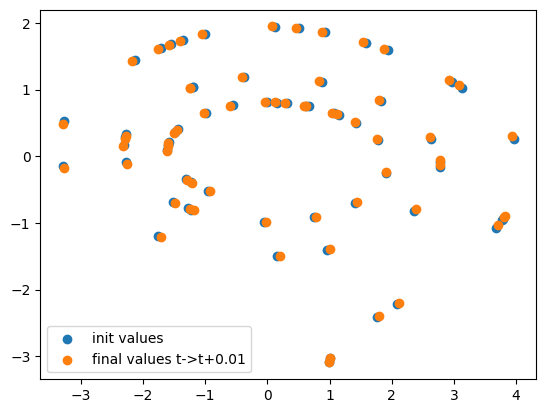

In [ ]:
plt.scatter(omega_i, theta_i, label="init values")
plt.scatter(omega_f, theta_f, label="final values t->t+"+str(propagation_time))
plt.legend()

In [ ]:
#training
epoch = 100
delta_t = 0.01

func = PendelumNetwork()
model = NeuralODE(func, delta_t)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


for k in range(epoch):
    avg_los = []
    for train_batch in train:
        x_i = train_batch[0]
        x_f = train_batch[1]
        prediction = model(x_i.to(device), propagation_time.to(device), use_adjoint = False)
        loss = torch.mean(torch.norm((prediction - x_f),dim=1)**2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_los.append(loss.item())
    if (k+1)%10==0:
        avg_los_2 = []
        for test_batch in test:
            x_i = test_batch[0]
            x_f = test_batch[1]
            prediction = model(x_i, propagation_time, use_adjoint= False)
            loss_ = torch.mean(torch.norm((prediction - x_f),dim=1)**2)
            avg_los_2.append(loss_.item())

        print(k+1 , "\t training ",np.mean(avg_los))
        print(" \t validation ",np.mean(avg_los_2))
        print("_________")


10 	 training  0.0015781195930663569
 	 validation  0.0007878369183512407
_________
20 	 training  0.0015774809438956667
 	 validation  0.0007871760466532677
_________
30 	 training  0.0015725664900477542
 	 validation  0.0007838586720805941
_________
40 	 training  0.001208583267603408
 	 validation  0.0005789169574665164
_________
50 	 training  0.0005744857837579634
 	 validation  0.0005971711293573925
_________
60 	 training  0.0005534444227024976
 	 validation  0.000481122298654236
_________
70 	 training  0.0005137178971508677
 	 validation  0.0003301965266770264
_________
80 	 training  0.00044728549085788105
 	 validation  0.00026640775540645497
_________
90 	 training  0.0004273501071899502
 	 validation  0.0002575248308180903
_________
100 	 training  0.00042128100855677255
 	 validation  0.00025305684403450856
_________


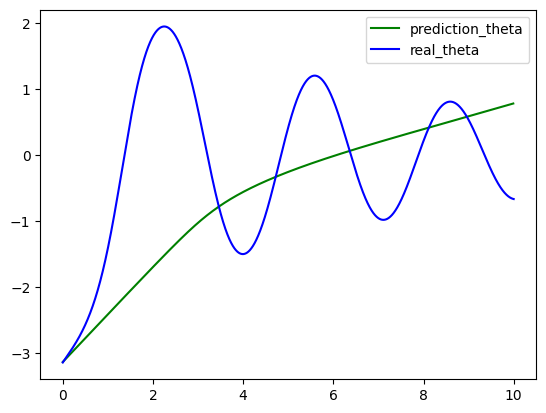

In [ ]:
prediction_theta = model(torch.tensor([[theta[0], omega[0]]],dtype=float), 10, True).T[0].detach().numpy()
prediction_omega = model(torch.tensor([[theta[0], omega[0]]],dtype=float), 10, True).T[1].detach().numpy()

plt.plot(np.arange(0, 10, delta_t),prediction_theta, label="prediction_theta", color="green")
plt.plot(t, theta,label="real_theta", color = "blue")
plt.legend()
plt.show()

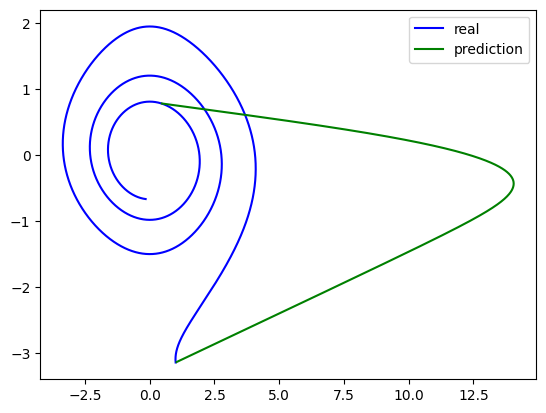

In [ ]:
plt.plot(omega, theta,label="real", color = "blue")
plt.plot(prediction_omega, prediction_theta,label="prediction", color = "green")
plt.legend()
plt.show()